In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Frequency and Basis Function Intuition

We've discussed the Fourier transform as a change of basis from a spacial domain to a frequency domain, but what does this really mean? When we talk about frequency in images, we refer to how quickly the values of the pixels change with respect to their location in the image. If every pixel is the same, the frequency present is the lowest possible, because there is no variation in pixel value with respect to their location. If the pixels values keep changing (from 0 to 1 and back), the frequency present is the highest possible.

To help you visulize the meaning of frequency, we will use the Discrete Cosine Transform (DCT), which is similar to the Fourier transform, except it has no imaginary component. Run the cells below to plot the DCT basis images.

In [7]:
def dct_basis(u,v):
    basis = np.zeros((8,8))
    for x in range(8):
        for y in range(8):
            basis[x,y] = np.cos(np.pi*(2*x+1)*u/16)*np.cos(np.pi*(2*y+1)*v/16)
    return basis

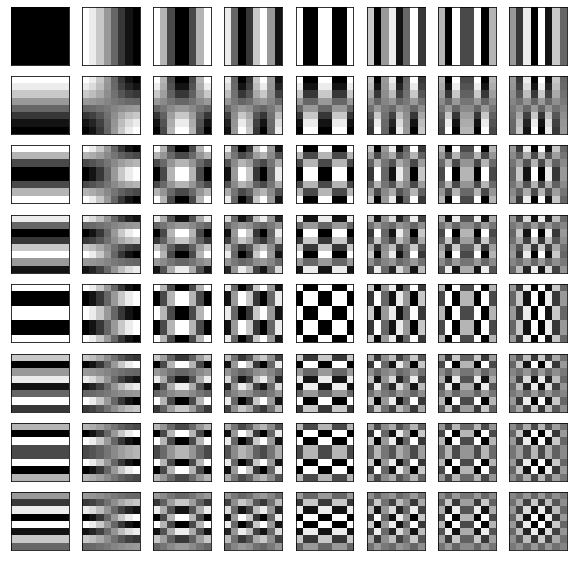

In [8]:
plt.figure(figsize=(10,10))
for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, 8*i+j+1)
        cur_axes = plt.gca()
        cur_axes.axes.get_xaxis().set_ticks([])
        cur_axes.axes.get_yaxis().set_ticks([])
        plt.imshow(dct_basis(i,j), cmap='gray')


The above images are the DCT basis images for 8x8 images. From left to right, we have the frequency increasing along the x axis of the image, and from top to bottom, we have the frequency increasing along the y axis. The top left has a frequency of 0 - the pixels in the image do not vary at all. And, in the bottom right, we have the highest frequency image - each adjacent pixel in the x and y directions is the opposite of that pixel.

You can think of every 8x8 image as the linear combination of these basis functions, and the DCT/DFT coeffecients as the weights of the linear combination.

# DFT and Image Manipulation

Let's now experiment with the DFT, and see how we can use it to manipulate images. Before we get the manipulation, let's read an image and take a look at its DFT.

In [9]:
def fft2c(im):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(im)))
    
def ifft2c(im):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(im)))

In [12]:
# The use of np.mean just converts RGB to greyscale by averaging the values in those channels
im = np.mean(plt.imread("lenna.png"), axis=2)
# im = np.mean(plt.imread("Lichtenstein_img_processing_test.png"), axis=2)

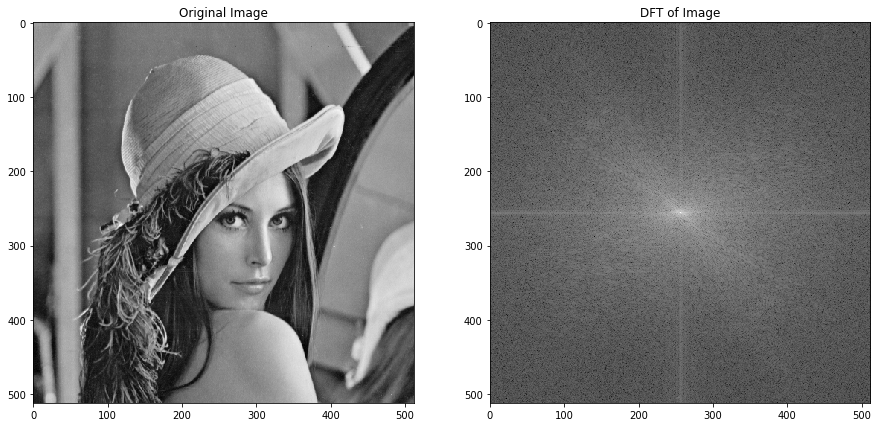

In [13]:
plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.imshow(im, cmap='gray')
plt.title("Original Image")

ft_im = fft2c(im)

plt.subplot(1, 2, 2)
plt.title("DFT of Image")
plt.imshow(np.log10(np.abs(ft_im)), cmap='gray')
plt.show()

The above DFT image shows the coeffecients of the DFT basis functions, where the brightness of each pixel indicates the magnitude of the corresponding basis function. The lowest frequency coeffecients are in the center of the image, and the highest frequeny coeffecients are towards the edges.

Let's now see how we can manipulate these coeffecients, and how those changes translate to changes in the image. We will do this by using the two functions below, `lpf` and `hpf`, which stand for low pass filter and high pass filter, respectively. The low pass filter "passes" low frequency coeffecients (zeros out high frequency coefficients), while the high pass filter does the opposite (zeros out low frequency coeffecients).

Let's take a look at what the coeffecients look like after applying the filters.

In [14]:
def lpf(im, r):
    filt_im = np.zeros(im.shape, dtype=np.complex64)
    c = np.array(im.shape)//2
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            pt = np.array([i,j])
            d = np.linalg.norm(pt-c)
            if d < r:
                filt_im[i,j] = im[i,j]
    return filt_im

def hpf(im, r):
    filt_im = np.zeros(im.shape, dtype=np.complex64)
    c = np.array(im.shape)//2
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            pt = np.array([i,j])
            d = np.linalg.norm(pt-c)
            if d > r:
                filt_im[i,j] = im[i,j]
    return filt_im

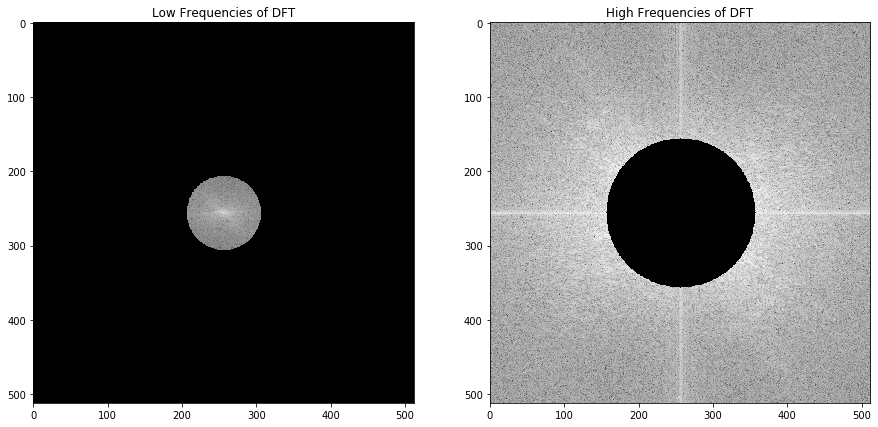

In [15]:
lpf_im = lpf(ft_im, 50)
hpf_im = hpf(ft_im, 100)

plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.title("Low Frequencies of DFT")
plt.imshow(np.log10(np.abs(lpf_im)+0.01), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("High Frequencies of DFT")
plt.imshow(np.log10(np.abs(hpf_im)+0.01), cmap='gray')
plt.show()

Now, if we take the inverse DFT of the filtered coeffecients, we can see how the images have changed

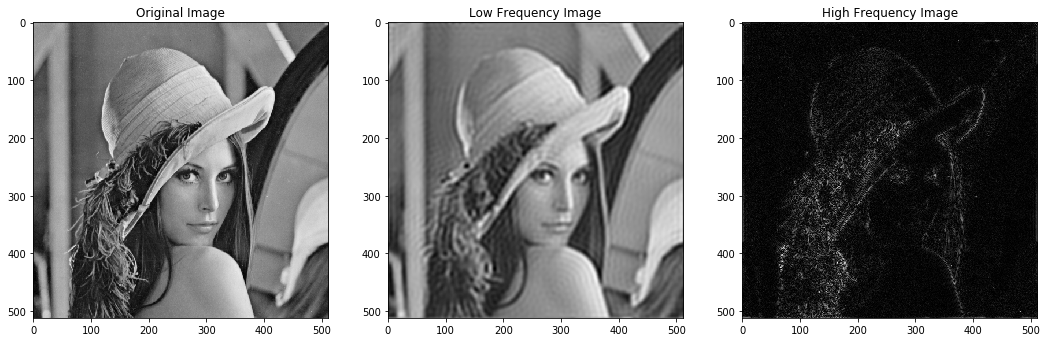

In [19]:
plt.figure(figsize=(18,10))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(im, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Low Frequency Image")
plt.imshow(np.abs(ifft2c(lpf_im)), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("High Frequency Image")
plt.imshow(np.abs(ifft2c(hpf_im)), cmap='gray')
plt.show()

In the low frequency image, we see more or less the same image, but with a "ringing" effect. What is important to note is that, even though we got a rid of a lot of coeffecients (we only kept around 3%), the image more or less looks the same. This idea is the key to using the Fourier transform for image compression, which we will take a closer look at next week.

The high frequency image highlights the edges in our image (because edges are where pixels vary the most), and this kind of technique can be used for object or edge detection.

# Wavelet Transform

Run the cell below to see the wavelet transform of our image.

In [17]:
wvlt_im = pywt.wavedec2(im, 'haar', level=3)
wvlt_im[0] /= np.abs(wvlt_im[0]).max()
data, slices = pywt.coeffs_to_array(wvlt_im)

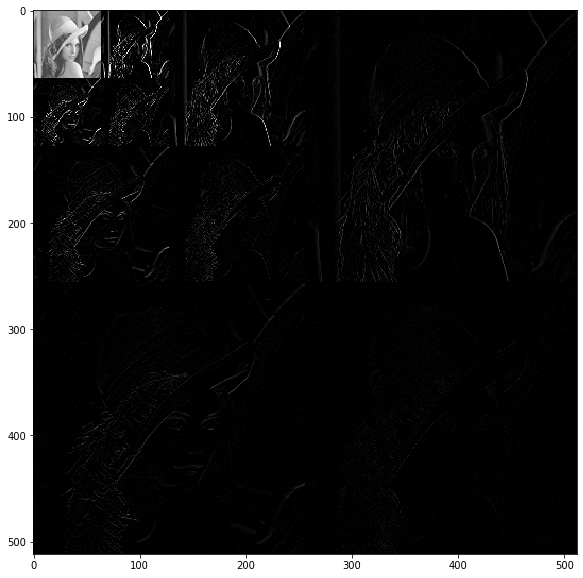

In [18]:
plt.figure(figsize=(15,10))
plt.imshow(data, cmap='gray', vmin=0, vmax=1)
plt.show()

To reiterate, the way this transform works is well beyond the scope of this class. What is important to note here is that the majority of the information is in the top left of our image, and the rest of the image is quite sparse. We will use this property of the wavelet transform next week for image compression.